In [580]:
fociID = input()

0A


In [581]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
celldf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/results/Results_pos%s.xls' %fociID,sep='\t')

In [569]:
celldf  = celldf.drop('Mean',1)
celldf = celldf.drop('X',1)
celldf = celldf.drop('Y',1)
celldf = celldf.drop('Perim.',1)
celldf = celldf.drop('Major',1)
celldf = celldf.drop('Minor',1)
#celldf.head(3)

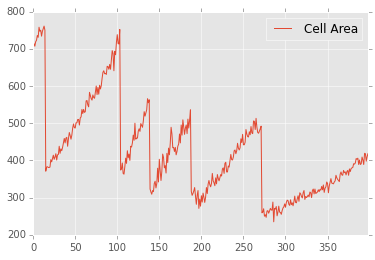

In [570]:
#Original data is in reverse-chronological because of backwards tracking in ImageJ
#Reverse order here so dataframe matches chronological order
celldf =celldf.reindex(index=celldf.index[::-1])
celldf = celldf.reset_index(drop=True)
celldf.Area.plot(label = 'Cell Area').legend(loc='upper right')

In [571]:
focidf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/FociResults/FociResults_Pos%s.xls'%fociID,sep='\t')


focidf = focidf.drop('Label', 1)
focidf = focidf.drop('Min', 1)
focidf = focidf.drop('Max', 1)
focidf = focidf.drop('Slice', 1)
focidf = focidf.drop(399) #the cell ROI data lacks the first slice, so delete it here to match

focidf =focidf.reindex(index=focidf.index[::-1])
focidf = focidf.reset_index(drop=True)

cellfocidisp = ((celldf.XM-focidf.XM)**2+(celldf.YM-focidf.YM)**2)**(1/2) 
#cellfocidisp.plot(label = 'Distance between Cell Center and Foci').legend(loc='upper left', bbox_to_anchor=(1, 0.5))

In [ ]:
cellx = celldf['XM']
celly = celldf['YM']
celldisp = pd.Series(((cellx[i+1]-cellx[i])**2+(celly[i+1]-celly[i])**2)**(1/2) for i in range (len(cellx)-1))
celldisp.plot()

In [ ]:
plt.figure();
plt.plot(focidf.XM, focidf.YM, alpha = 0.7, label = 'Foci')
plt.plot(celldf.XM, celldf.YM, 'c-', alpha = 0.7, label = 'Cell Center')
plt.legend()

In [ ]:
rad = np.radians(celldf['Angle']) #convert cell ROI long axis angle to radians

radfoci = rad-np.arctan2(focidf['YM'],focidf['XM']) #convert foci polar coordinate theta taking into account the ROI's angle

polardisp= pd.Series((cellfocidisp[i+1]**2+cellfocidisp[i]**2-2*cellfocidisp[i]*cellfocidisp[i+1]*np.cos(radfoci[i+1]-radfoci[i]))**(1/2) for i in range (len(cellfocidisp)-1))

#polardisp.plot(label = 'Polar Displacement').legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
#Replace the outliers in Polar displacements with mean
for x in polardisp:
    if x>8:
        polardisp[polardisp == x]=polardisp.mean()

In [ ]:
focix = focidf['XM']
fociy = focidf['YM']
cartdisp = pd.Series(((focix[i+1]-focix[i])**2+(fociy[i+1]-fociy[i])**2)**(1/2) for i in range (len(focix)-1))
#cartdisp.plot(label = 'Cartesian Displacement').legend(loc='center left', bbox_to_anchor=(1, 0.5))

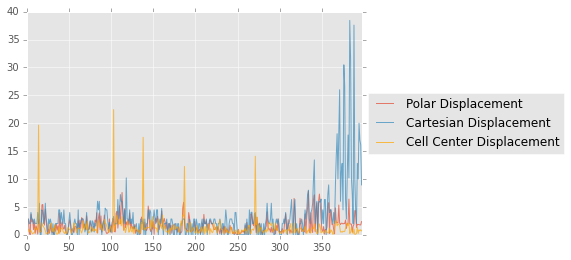

In [579]:
plt.figure();

polardisp.plot(label = 'Polar Displacement', alpha = 0.7)
cartdisp.plot( label = 'Cartesian Displacement', alpha = 0.7)
celldisp.plot(label='Cell Center Displacement', alpha=0.7, color='orange')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#celldf.Area.plot(ax = ax2, color = '#E8D66F', label = 'Cell Area',  alpha = 0.7)


In [ ]:
dispdf = pd.DataFrame({'Cartesian': cartdisp, 'Polar': polardisp})
#dispdf.head(3)

plt.figure();
dispdf.hist(bins=[0,4,8,12,16], color='Black', alpha=0.7)

In [ ]:
#extract division timepoints
division = celldisp[celldisp>10].index 

#Set generation number for each timepoint
generation = pd.Series(range(len(polardisp)+1))

for i in range(len(division)+1):
    if i == 0: #Generation1
        generation[:division[i]+1]= 1
    elif i == len(division): #Last Generation
        generation[division[i-1]:]=i+1
    else:    
        generation[division[i-1]+1:division[i]+1]= i+1

In [ ]:
division

In [574]:
celldf['Foci X'] = focix
celldf['Foci Y'] = fociy
celldf['Cartesian_Displacement'] = cartdisp
celldf['Polar_Displacement'] = polardisp
celldf['Generation'] = generation
celldf.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/data_pos%s.csv'%fociID, sep=',')

In [ ]:
gendict = {}
gentimedict = {}
gencartmeandict={}
gencartcvdict={}
genpolarmeandict = {}
genpolarcvdict = {}
gengrowthdict = {}
for n in range(2,len(division)+1):  #omit first and last generation
    gendict[n] = celldf[celldf.Generation==n]
    gentimedict[n] = len(gendict[n])
    gencartmeandict[n]=gendict[n].Cartesian_Displacement.mean()
    gencartcvdict[n] = gendict[n].Cartesian_Displacement.std()/gendict[n].Cartesian_Displacement.mean()
    genpolarmeandict[n] = gendict[n].Polar_Displacement.mean()
    genpolarcvdict[n] = gendict[n].Polar_Displacement.std()/gendict[n].Polar_Displacement.mean()
    gengrowthdict[n] = (np.log(gendict[n].Area.iloc[-1] /gendict[n].Area.iloc[0]))/gentimedict[n]

In [ ]:
gendf=pd.DataFrame()


gengrowth = pd.Series(gengrowthdict)
gentime=pd.Series(gentimedict)
gencartmean = pd.Series(gencartmeandict)
gencartcv = pd.Series(gencartcvdict)
genpolarmean = pd.Series(genpolarmeandict)
genpolarcv = pd.Series(genpolarcvdict)


gendf['Generation_Time']=gentime
gendf['Elongation_Rate'] =gengrowth

gendf['Mean_Cartesian_Displacement'] = gencartmean
gendf['CV_Cartesian_Displacement'] = gencartcv

gendf['Mean_Polar_Displacement'] = genpolarmean
gendf['CV_Polar_Displacement'] = genpolarcv
gendf.index.name = 'Generation'

gendf.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/generationdata_pos%s.csv'%fociID, sep=',')

In [ ]:
ax = gendf.plot(kind='scatter', x = 'Mean_Cartesian_Displacement', y = 'Elongation_Rate_min-1', alpha=0.7,label = 'Mean Cart Disp',color='Blue')
gendf.plot(kind='scatter', x = 'Mean_Polar_Displacement', y = 'Elongation_Rate_min-1',alpha=0.7,label = 'Mean Polar Disp', color='Red', ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2= gendf.plot(kind='scatter', x = 'CV_Cartesian_Displacement', y = 'Elongation_Rate_min-1', alpha=0.7,label = 'CV of Cart Disp', color='Orange')
gendf.plot(kind='scatter', x = 'CV_Polar_Displacement', y = 'Elongation_Rate_min-1', alpha=0.7,label = 'CV of Polar Disp', color='Black',ax=ax2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax3 = gendf.plot(kind='scatter', x = 'Mean_Cartesian_Displacement', y = 'Generation_Time', alpha=0.7,label = 'Mean Cart Disp',color='Blue')
gendf.plot(kind='scatter', x = 'Mean_Polar_Displacement', y = 'Generation_Time',alpha=0.7,label = 'Mean Polar Disp', color='Red', ax=ax3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4= gendf.plot(kind='scatter', x = 'CV_Cartesian_Displacement', y = 'Generation_Time', alpha=0.7,label = 'CV of Cart Disp', color='Orange')
gendf.plot(kind='scatter', x = 'CV_Polar_Displacement', y = 'Generation_Time', alpha=0.7,label = 'CV of Polar Disp', color='Black',ax=ax4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



### Batch Ideas
I remember using a Perl script? that reads in a different script and allows passing multiple files from the command line like `$script.pl *.txt`

### 150909BossDiscussion
- Check relation of foci displacement and cell size. Larger cells mean that the foci would appear to move longer compared to that within smaller cells.
- Per-frame cell size and per-frame foci displacement correlation = linear?
- Fit cell elongation with a exponential function and obtain smoothed cell size
- Compare two distinct foci within cells with same size: will their displacement differ?


In [ ]:
celldf.plot(kind='scatter', x='Area', y='Polar_Displacement');

In [ ]:
a=[1,2,3]
len(a)